In [ ]:
import numpy as np
from scipy.integrate import dblquad
from scipy.optimize import fsolve
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def K_stern_w(y,x):
    return np.cos(2*np.pi*x)+np.cos(2*np.pi*y)-np.cos(2*np.pi*x)*np.cos(2*np.pi*y)

def indicator_func (y,x):
    return 1

def Doppelintegral(f,a,b,c,d):
    return dblquad(f,a,b,c,d)[0]


#boundaries for the integral

def x_links(delta,a): # left outer
    return (np.arccos((a+1)/(2)))/(2*np.pi) + delta 

def x_rechts(delta, a): # right outer
    return  1- (np.arccos((a+1)/(2)))/(2*np.pi) - delta

def y_unten(x, a):
    return (np.arccos((a - np.cos(2*np.pi*x))/(1-np.cos(2*np.pi*x))))/(2*np.pi)

def y_oben(x, a):
    return 1 - (np.arccos(( a- np.cos(2*np.pi*x))/(1-np.cos(2*np.pi*x))))/(2*np.pi)

def y_unten_min(epsilon, a):
    return (np.arccos((a+1)/(2)))/(2*np.pi) + epsilon

def y_oben_max (epsilon, a):
    return 1- (np.arccos((a+1)/(2)))/(2*np.pi) - epsilon 


def x_links_innen(epsilon, a):
    def equation(x):
        return (np.arccos((a-np.cos(2*np.pi*x))/(1-np.cos(2*np.pi*x))))/(2*np.pi) - (np.arccos((a+1)/(2)))/(2*np.pi) - epsilon
    
    startwert = 0.2  
    numerical_solution = fsolve(equation, startwert)
    return numerical_solution

def x_rechts_innen(epsilon, a):
    return 1 - x_links_innen(epsilon, a)

def Per(delta, epsilon, a):
    return 2*(x_rechts(delta,a)-x_links(delta, a)) + 2 * (y_oben_max(epsilon, a) - y_unten_min(epsilon, a))

    
# combines level sets and truncation
def J(delta, epsilon, a):
    if x_links(delta,a) < x_links_innen(epsilon, a):
        return (-1 / Per(delta, epsilon, a) * (
            abs(Doppelintegral(K_stern_w, x_links(delta, a), x_links_innen(epsilon, a), 
                                lambda x: y_unten(x,a), lambda x: y_oben(x,a)) +
                Doppelintegral(K_stern_w, x_links_innen(epsilon,a), x_rechts_innen(epsilon,a), 
                                y_unten_min(epsilon,a), y_oben_max(epsilon,a)) + 
                Doppelintegral(K_stern_w, x_rechts_innen(epsilon, a), x_rechts(delta, a), lambda x: y_unten(x,a), lambda x: y_oben(x,a)))))
    else:
        return (-1/Per(delta, epsilon, a) *  abs(Doppelintegral(K_stern_w, x_links(delta,a), x_rechts(delta,a), 
                                y_unten_min(epsilon,a), y_oben_max(epsilon,a))))


# truncation just horizontal/vertical
def J_tilde(delta, epsilon):
     return (-1/Per(delta, epsilon, 0) * abs(Doppelintegral(K_stern_w, x_links(delta,0), x_rechts(delta,0), 
                                                            y_unten_min(epsilon,0), y_oben_max(epsilon,0))))

# just varying level sets
def J_hat(a):
    return ((-1/Per(0,0,a)) * abs(Doppelintegral(K_stern_w, x_links(0,a), x_rechts(0,a), lambda x: y_unten(x,a), lambda x : y_oben(x,a))))

In [ ]:
#level sets and left/right/top/bottom truncation

def J_wrapper(x):
    delta, epsilon, a = x
    try:
        return J(delta, epsilon, a)
    except:
        return 1e6  

# starting value
x0 = [0.05, 0.05, -0.1]

# boundaries
bounds = [(0, 0.2), (0, 0.2), (-1, 0)]

result_combined = minimize(J_wrapper, x0, method='L-BFGS-B', bounds=bounds)


print("optimal parameters:", result_combined.x)
print("minimal value of J:", result_combined.fun)

optimal parameters: [ 0.09606103  0.09606103 -0.10982267]
minimal value of J: -0.21213299475310282


In [ ]:
# Level sets

def J_hat_wrapper(x):
    a = x
    try:
        return J_hat( a)
    except:
        return 1e6 

# sarting value
x0 = [0]

# boundaries
bounds = [(-2, 0.4)]

result_level = minimize(J_hat_wrapper, x0, method='L-BFGS-B', bounds=bounds)

print("optimal parameters:", result_level.x)
print("minimal value of J:", result_level.fun)

optimal parameters: [-0.89388304]
minimal value of J: -0.19378909668470864


In [ ]:
# rectangles

def J_tilde_wrapper(x):
    delta, epsilon = x
    try:
        return J_tilde(delta, epsilon)
    except:
        return 1e6 
        

# sarting value
x0 = [0.1, 0.1]

# boundaries
bounds = [(0, 0.3), (0, 0.3)]

result_rect = minimize(J_tilde_wrapper, x0, method='L-BFGS-B', bounds=bounds)

print("optimal parameters:", result_rect.x)
print("minimal value of J:", result_rect.fun)

optimal parameters: [0.10598146 0.10598146]
minimal value of J: -0.21213299475576258


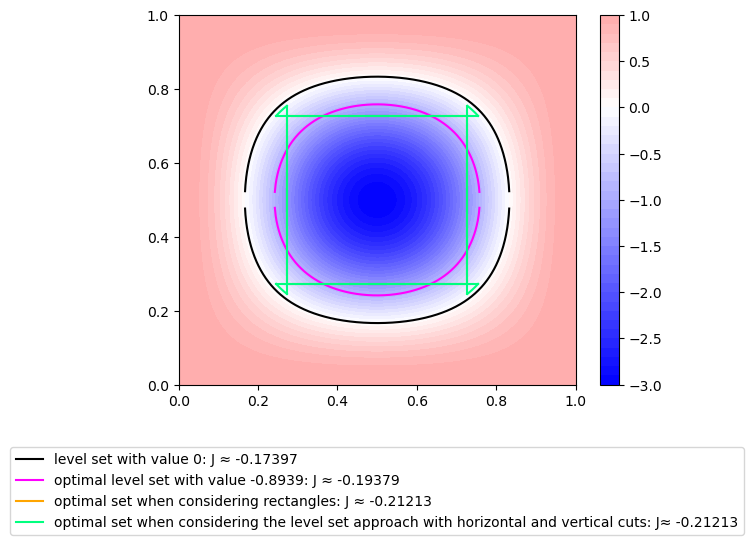

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
x, y = np.meshgrid(x, y)

z = np.cos(2*np.pi*x)+np.cos(2*np.pi*y)-np.cos(2*np.pi*x)*np.cos(2*np.pi*y)


vmax = np.max(np.abs(z))
# top view
plt.contourf(x, y, z, 40, cmap='bwr', vmin = -vmax, vmax=vmax) 
plt.colorbar(label='')


#level set value 0
plt.plot(x[0], y_unten(x[0],0 ), color='black' )
plt.plot(x[0], y_oben(x[0],0), color='black', label=f'level set with value 0: J \u2248 {np.round(J_hat(0),5)}' )

#optimal level set
plt.plot(x[0], y_unten(x[0],result_level.x[0] ), color='magenta' )
plt.plot(x[0], y_oben(x[0],result_level.x[0]), color='magenta', label=f'optimal level set with value {np.round(result_level.x[0], 4)}: J \u2248 {np.round(result_level.fun,5)}' )
  



# optimal rectangle
plt.plot([x_links(result_rect.x[0], 0), x_links(result_rect.x[0], 0)], 
         [y_unten_min(result_rect.x[1],0),y_oben_max(result_rect.x[1], 0) ], 
         color='orange')

plt.plot([x_rechts(result_rect.x[0], 0), x_rechts(result_rect.x[0],0)], 
         [y_unten_min(result_rect.x[1], 0 ),y_oben_max(result_rect.x[1], 0) ], 
         color='orange')

plt.plot([x_links(result_rect.x[0],0), x_rechts(result_rect.x[0], 0)], 
         [y_unten_min(result_rect.x[1],0 ),y_unten_min(result_rect.x[1], 0) ], 
         color='orange')

plt.plot([x_links(result_rect.x[0], 0), x_rechts(result_rect.x[0], 0)], 
         [y_oben_max(result_rect.x[1],0 ),y_oben_max(result_rect.x[1], 0) ], 
         color='orange', label=f'optimal set when considering rectangles: J \u2248 {np.round(result_rect.fun,5)}')

  

# level set shaped parts
x_linie1= np.linspace(x_links(result_combined.x[0], result_combined.x[2] ), x_links_innen(result_combined.x[1], result_combined.x[2] ), 200)
y_linie1= y_unten(x_linie1 , result_combined.x[2] )
plt.plot(x_linie1, y_linie1, color='springgreen')

x_linie2= np.linspace(x_links(result_combined.x[0], result_combined.x[2] ), x_links_innen(result_combined.x[1], result_combined.x[2] ), 200)
y_linie2= y_oben(x_linie2 , result_combined.x[2] )
plt.plot(x_linie2, y_linie2, color='springgreen')

x_linie3= np.linspace(x_rechts_innen(result_combined.x[1], result_combined.x[2] ), x_rechts(result_combined.x[0], result_combined.x[2]), 200)
y_linie3= y_unten(x_linie3 , result_combined.x[2] )
plt.plot(x_linie3, y_linie3, color='springgreen')

x_linie4= np.linspace(x_rechts_innen(result_combined.x[1], result_combined.x[2] ), x_rechts(result_combined.x[0], result_combined.x[2] ), 200)
y_linie4= y_oben(x_linie4 ,result_combined.x[2] )
plt.plot(x_linie4, y_linie4, color='springgreen')

# horizontal/vertical boundaries
plt.plot([x_links(result_combined.x[0], result_combined.x[2]), x_links(result_combined.x[0], result_combined.x[2])], 
         [x_links_innen(result_combined.x[1], result_combined.x[2] ),x_rechts_innen(result_combined.x[1], result_combined.x[2]) ], 
         color='springgreen')

plt.plot([x_rechts(result_combined.x[0], result_combined.x[2]), x_rechts(result_combined.x[0], result_combined.x[2])], 
         [x_links_innen(result_combined.x[1], result_combined.x[2] ),x_rechts_innen(result_combined.x[1], result_combined.x[2]) ], 
         color='springgreen')

plt.plot([x_links_innen(result_combined.x[1], result_combined.x[2]), x_rechts_innen(result_combined.x[1], result_combined.x[2])], 
         [x_links(result_combined.x[0], result_combined.x[2] ),x_links(result_combined.x[0], result_combined.x[2]) ], 
         color='springgreen')

plt.plot([x_links_innen(result_combined.x[1], result_combined.x[2]), x_rechts_innen(result_combined.x[1], result_combined.x[2])], 
         [x_rechts(result_combined.x[0], result_combined.x[2]),x_rechts(result_combined.x[0], result_combined.x[2]) ], 
         color='springgreen', label=f'optimal set when considering the level set approach with horizontal and vertical cuts: J\u2248 {np.round(result_combined.fun,5)}')
 


plt.title('')
plt.xlabel('')
plt.ylabel('')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

plt.show()



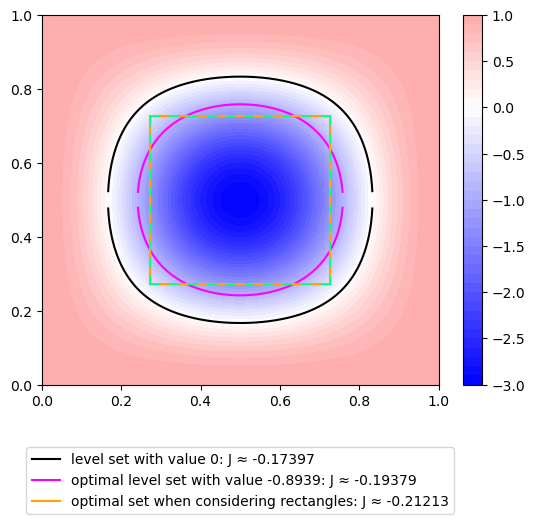

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def coloured_lines(x, y, farbe1='orange', farbe2='springgreen', n_striche=10):

    x = np.linspace(x[0], x[1], n_striche * 2)
    y = np.linspace(y[0], y[1], n_striche * 2)
    for i in range(0, len(x) - 1, 2):
        plt.plot(x[i:i+2], y[i:i+2], color=farbe2, linewidth=1)
        if i + 2 < len(x):
            plt.plot(x[i+1:i+3], y[i+1:i+3], color=farbe1, linewidth=1)

x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
x, y = np.meshgrid(x, y)

z = np.cos(2*np.pi*x)+np.cos(2*np.pi*y)-np.cos(2*np.pi*x)*np.cos(2*np.pi*y)


vmax = np.max(np.abs(z))
# top view
plt.contourf(x, y, z, 40, cmap='bwr', vmin = -vmax, vmax=vmax) 
plt.colorbar(label='')


#level set value 0
plt.plot(x[0], y_unten(x[0],0 ), color='black' )
plt.plot(x[0], y_oben(x[0],0), color='black', label=f'level set with value 0: J \u2248 {np.round(J_hat(0),5)}' )

#optimal level set
plt.plot(x[0], y_unten(x[0],result_level.x[0] ), color='magenta' )
plt.plot(x[0], y_oben(x[0],result_level.x[0]), color='magenta', label=f'optimal level set with value {np.round(result_level.x[0], 4)}: J \u2248 {np.round(result_level.fun,5)}' )
  



# optimal rectangle
plt.plot([x_links(result_rect.x[0], 0), x_links(result_rect.x[0], 0)], 
         [y_unten_min(result_rect.x[1],0),y_oben_max(result_rect.x[1], 0) ], 
         color='orange')

plt.plot([x_rechts(result_rect.x[0], 0), x_rechts(result_rect.x[0],0)], 
         [y_unten_min(result_rect.x[1], 0 ),y_oben_max(result_rect.x[1], 0) ], 
         color='orange')

plt.plot([x_links(result_rect.x[0],0), x_rechts(result_rect.x[0], 0)], 
         [y_unten_min(result_rect.x[1],0 ),y_unten_min(result_rect.x[1], 0) ], 
         color='orange')

plt.plot([x_links(result_rect.x[0], 0), x_rechts(result_rect.x[0], 0)], 
         [y_oben_max(result_rect.x[1],0 ),y_oben_max(result_rect.x[1], 0) ], 
         color='orange', label=f'optimal set when considering rectangles: J \u2248 {np.round(result_rect.fun,5)}')

  
coloured_lines(
    [x_links(result_rect.x[0], 0), x_links(result_rect.x[0], 0)],
    [y_unten_min(result_rect.x[1], 0), y_oben_max(result_rect.x[1], 0)]
)

coloured_lines(
    [x_rechts(result_rect.x[0], 0), x_rechts(result_rect.x[0], 0)],
    [y_unten_min(result_rect.x[1], 0), y_oben_max(result_rect.x[1], 0)]
)

coloured_lines(
    [x_links(result_rect.x[0], 0), x_rechts(result_rect.x[0], 0)],
    [y_unten_min(result_rect.x[1], 0), y_unten_min(result_rect.x[1], 0)]
)

coloured_lines(
    [x_links(result_rect.x[0], 0), x_rechts(result_rect.x[0], 0)],
    [y_oben_max(result_rect.x[1], 0), y_oben_max(result_rect.x[1], 0)]
)


plt.savefig('example1_optimal_boundaries.png')  

plt.title('')
plt.xlabel('')
plt.ylabel('')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

plt.show()



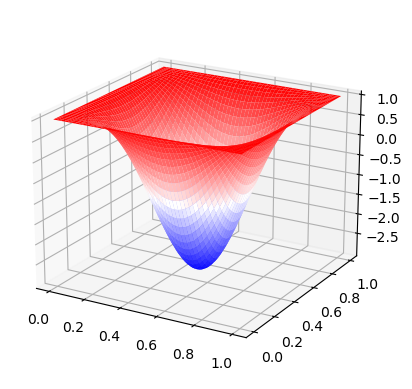

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
x, y = np.meshgrid(x, y)  # Erzeugt ein Gitter
z =  np.cos(2*np.pi*x)+np.cos(2*np.pi*y)-np.cos(2*np.pi*x)*np.cos(2*np.pi*y)

ax.plot_surface(x, y, z, cmap='bwr')

ax.view_init(20)

ax.set_title('')
plt.savefig('example1.png') 
plt.show()
